### Importations des bibliothèques

In [ ]:
import numpy as np  
import pandas as pd
from datetime import datetime
import geopy.distance

### Fonctions

In [ ]:
def TimeDiff(date_1, date_2):
  """
    Cette fonction permet de calculer la durée entre deux dates
    :params: 
        date_1: date in format %Y-%m-%d %H:%M:%S+%f
        date_2: date in format %Y-%m-%d %H:%M:%S+%f
     :return:
        diff_in_hours: int (difference in hours)
  """
  date_format_str = '%Y-%m-%d %H:%M:%S+%f'
  start = datetime.strptime(date_1, date_format_str)
  end =   datetime.strptime(date_2, date_format_str)
  diff = end - start
  diff_in_hours = diff.total_seconds() / 3600
  return (diff_in_hours)

In [ ]:
# Calculer la distance entre deux coordonnées
def distances(coords_1, coords_2):
  return(geopy.distance.geodesic(coords_1, coords_2).km)

In [ ]:
# Ajouter la colonne de dureé de trajet dans le dataframe
def add_duration(df):
  duration=[]
  for i,trial in df.iterrows():
    duration.append(TimeDiff(df.loc[i, "departure_ts"],df.loc[i, "arrival_ts"]))
  df['duration']=duration
  return(df)

In [ ]:
# Ajouter la colonne des trajet dans le dataframe
def add_traget(df):
  traget=[]
  for i,trial in df.iterrows():
    traget.append(df.loc[i, "o"]+' to '+df.loc[i, "d"])
  df['traget']=traget
  return(df)


In [ ]:
# Ajouter la colonne de distance du chemin dans le dataframe
def add_distance(df):
  dis=[]
  for i,trial in df.iterrows():
    dis.append(distances(((df.loc[i, "latitude_depart"]),(df.loc[i, "longitude_depart"])),
    ((df.loc[i, "latitude_destination"]),(df.loc[i, "longitude_destination"]))))
  df['distance']=dis
  return(df)

In [ ]:
#suppression de l'anomalie dans la colonne de la durée 
def removing_Outlier(df):
  l=list(df['duration'].quantile([0.25,0.5,0.75]))
  IQR = l[2] -l[0]
  Upper_Bound=(l[2] + 1.5 * IQR)
  def keep(dis):
    if dis <= Upper_Bound :
      return(True)
    else:
      return(False)
  df['keep'] = df['duration'].apply(keep)
  df= df[df.keep == True]
  return(df)


In [ ]:
#Ajout d'une colonne de plage des distances dans le data frame
def add_RangeDistance(df):
  l=list(df['distance'].quantile([0.25,0.5,0.75]))
  def RangeDistance(dis):
    if 0 <= dis and dis <= l[0]:
      return('0-206km')
    elif dis <= l[1]:
      return('207-339km')
    elif dis <= l[2]:
      return('340-481km')
    else:
      return('481+km')
  df['RangeDistance'] = df['distance'].apply(RangeDistance)
  return(df)

### Importation des données

In [12]:
cities = pd.read_csv("./data/cities.csv")
providers = pd.read_csv("./data/providers.csv")
stations = pd.read_csv("./data/stations.csv")
tickets = pd.read_csv("./data/ticket_data.csv")

In [13]:
# Aperçu de l'ensemble des données relatives aux villes 
display(cities)
#Les statistiques descriptives correspondantes
cities.describe()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN
...,...,...,...,...,...,...
8035,9964,"Saint-André-lez-Lille, Hauts-de-France, France",saint-andre-lez-lille,50.654250,3.047690,NaN
8036,10863,"Kiev, Шевченківський район, Ukraine",kiev,50.450100,30.523400,NaN
8037,11144,"Brighton, England, UK",brighton,50.822000,-0.137400,NaN
8038,11377,"Manises, Comunitat Valenciana, España",manises,39.493000,-0.462100,NaN


,id,latitude,longitude,population
count,8040.000000,8040.000000,8040.000000,3.690000e+02
mean,6328.786816,47.223456,6.299331,3.360184e+05
std,3504.698537,3.700934,7.747070,5.840409e+05
min,1.000000,1.370676,-101.397388,1.000460e+05
25%,2501.500000,44.662402,1.214282,1.253750e+05
50%,7003.500000,47.304750,4.887856,1.803020e+05
75%,9014.250000,49.611998,10.311597,3.098690e+05
max,12192.000000,64.145981,48.731938,8.416535e+06


In [14]:
# Aperçu de l'ensemble des données relatives aux fournisseurs
display(providers)
# Les statistiques descriptives correspondantes
providers.describe()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus
...,...,...,...,...,...,...,...,...,...,...
222,8384,10,16,thalys,Thalys,True,True,False,True,train
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
224,8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus
225,8388,40,NaN,beauval,Beauval,NaN,NaN,NaN,NaN,bus


,id,company_id
count,227.000000,227.000000
mean,790.656388,9.343612
std,2251.823950,3.036065
min,9.000000,1.000000
25%,66.500000,9.000000
50%,127.000000,9.000000
75%,183.500000,9.000000
max,8389.000000,40.000000


In [15]:
# Aperçu de l'ensemble des données relatives aux stations
display(stations)
# Les statistiques descriptives correspondantes
stations.describe()

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737
...,...,...,...,...
11030,11032,Porto Avda De Los Aliados,41.146922,-8.611122
11031,11033,Rom Ciampino Flughafen Piazzale Leonardo da Vinci,41.804102,12.597110
11032,11034,Sants,41.379892,2.139462
11033,11035,Vozilici D66,45.157136,14.164140


,id,latitude,longitude
count,11035.000000,11035.000000,11035.000000
mean,5518.026914,47.526678,7.580807
std,3185.719813,3.953972,63.655681
min,1.000000,-22.355790,-22.625538
25%,2759.500000,44.896447,1.358655
50%,5518.000000,47.759670,5.824010
75%,8276.500000,50.349956,12.166133
max,11036.000000,64.137571,6645.000000


In [16]:
# Aperçu de l'ensemble des données relatives aux tickets
display(tickets)
# Les statistiques descriptives correspondantes
tickets.describe()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562


,id,company,o_station,d_station,price_in_cents,o_city,d_city
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000


### Extraction d'informations intéressantes et visualisation


1.   Joindre et fusionner les données nécessaires provenant de différents data frames



In [17]:
# Conserver les données nécessaires de l'ensemble des données des tickets
All_data=tickets[['id','company','price_in_cents', 'o_city','d_city' ,'o_station','d_station','departure_ts','arrival_ts']]

In [18]:
# Ajout du nom des villes de départ dans l'ensemble de données
All_data=pd.merge(All_data, cities[['id','unique_name']], left_on='o_city', right_on='id',how='left')
All_data.rename(columns={'unique_name':'o'},inplace=True)
All_data=All_data.drop(['id_y'],axis=1)
# Ajout du nom des villes d'arrivé dans l'ensemble de données
All_data=pd.merge(All_data, cities[['id','unique_name']], left_on='d_city', right_on='id',how='left')
All_data.rename(columns={'unique_name':'d'},inplace=True)
All_data=All_data.drop(['id'],axis=1)
display(All_data)

,id_x,company,price_in_cents,o_city,d_city,o_station,d_station,departure_ts,arrival_ts,o,d
0,6795025,8385,4550,611,542,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,orleans,montpellier
1,6795026,9,1450,611,542,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,orleans,montpellier
2,6795027,8377,7400,611,542,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,orleans,montpellier
3,6795028,8377,13500,611,542,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,orleans,montpellier
4,6795029,8381,7710,611,542,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,orleans,montpellier
...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,2590,628,562,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,paris,nantes
74164,6869185,9,2700,628,562,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,paris,nantes
74165,6869187,8371,3000,628,562,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,paris,nantes
74166,6869189,13,2880,628,562,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,paris,nantes


In [19]:
# Ajout des coordonnées des villes dans le data frame 
All_data=pd.merge(All_data, cities[['latitude','longitude','unique_name']], left_on='o', right_on='unique_name',how='left')
All_data.rename(columns={'latitude':'latitude_depart','longitude':'longitude_depart'},inplace=True)
All_data=pd.merge(All_data, cities[['latitude','longitude','unique_name']], left_on='d', right_on='unique_name',how='left')
All_data.rename(columns={'latitude':'latitude_destination','longitude':'longitude_destination'},inplace=True)

In [20]:
# Ajout de compagnies de voyage et de leurs offres le data frame 
All_data=pd.merge(All_data, providers[['id','transport_type','has_bicycle','has_adjustable_seats','has_plug','has_wifi','fullname']], left_on='company', right_on='id',how='left')
display(All_data)

,id_x,company,price_in_cents,o_city,d_city,o_station,d_station,departure_ts,arrival_ts,o,...,latitude_destination,longitude_destination,unique_name_y,id,transport_type,has_bicycle,has_adjustable_seats,has_plug,has_wifi,fullname
0,6795025,8385,4550,611,542,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,orleans,...,43.604452,3.918318,montpellier,8385,carpooling,False,False,False,False,Blablacar
1,6795026,9,1450,611,542,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,orleans,...,43.604452,3.918318,montpellier,9,bus,False,True,True,True,Ouibus
2,6795027,8377,7400,611,542,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,orleans,...,43.604452,3.918318,montpellier,8377,train,False,True,False,False,Intercités
3,6795028,8377,13500,611,542,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,orleans,...,43.604452,3.918318,montpellier,8377,train,False,True,False,False,Intercités
4,6795029,8381,7710,611,542,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,orleans,...,43.604452,3.918318,montpellier,8381,train,False,True,False,False,Intercités de Nuit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,2590,628,562,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,paris,...,47.248785,-1.520898,nantes,13,bus,False,False,False,True,Flixbus
74164,6869185,9,2700,628,562,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,paris,...,47.248785,-1.520898,nantes,9,bus,False,True,True,True,Ouibus
74165,6869187,8371,3000,628,562,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,paris,...,47.248785,-1.520898,nantes,8371,bus,False,True,True,True,Isilines
74166,6869189,13,2880,628,562,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,paris,...,47.248785,-1.520898,nantes,13,bus,False,False,False,True,Flixbus


2.    Ajout des colonnes "traget","distance","duration" et"RangeDistance"


 


In [21]:
All_data=add_traget(All_data)
All_data=add_distance(All_data)
All_data=add_duration(All_data)
All_data=add_RangeDistance(All_data)
#keeping necessary informations
All_data=All_data[['id_x','o', 'd','company', 'price_in_cents','transport_type',
       'has_bicycle', 'has_adjustable_seats', 'has_plug', 'has_wifi',
       'fullname', 'traget', 'distance', 'duration','RangeDistance','o_city','d_city']]
display(All_data)

,id_x,o,d,company,price_in_cents,transport_type,has_bicycle,has_adjustable_seats,has_plug,has_wifi,fullname,traget,distance,duration,RangeDistance,o_city,d_city
0,6795025,orleans,montpellier,8385,4550,carpooling,False,False,False,False,Blablacar,orleans to montpellier,503.136831,6.166667,481+km,611,542
1,6795026,orleans,montpellier,9,1450,bus,False,True,True,True,Ouibus,orleans to montpellier,503.136831,17.833333,481+km,611,542
2,6795027,orleans,montpellier,8377,7400,train,False,True,False,False,Intercités,orleans to montpellier,503.136831,31.950000,481+km,611,542
3,6795028,orleans,montpellier,8377,13500,train,False,True,False,False,Intercités,orleans to montpellier,503.136831,21.583333,481+km,611,542
4,6795029,orleans,montpellier,8381,7710,train,False,True,False,False,Intercités de Nuit,orleans to montpellier,503.136831,21.766667,481+km,611,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,paris,nantes,13,2590,bus,False,False,False,True,Flixbus,paris to nantes,339.046766,13.500000,207-339km,628,562
74164,6869185,paris,nantes,9,2700,bus,False,True,True,True,Ouibus,paris to nantes,339.046766,6.500000,207-339km,628,562
74165,6869187,paris,nantes,8371,3000,bus,False,True,True,True,Isilines,paris to nantes,339.046766,6.750000,207-339km,628,562
74166,6869189,paris,nantes,13,2880,bus,False,False,False,True,Flixbus,paris to nantes,339.046766,7.750000,207-339km,628,562


3.   Visualisation des prix et des durées selon les différents types de transport


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


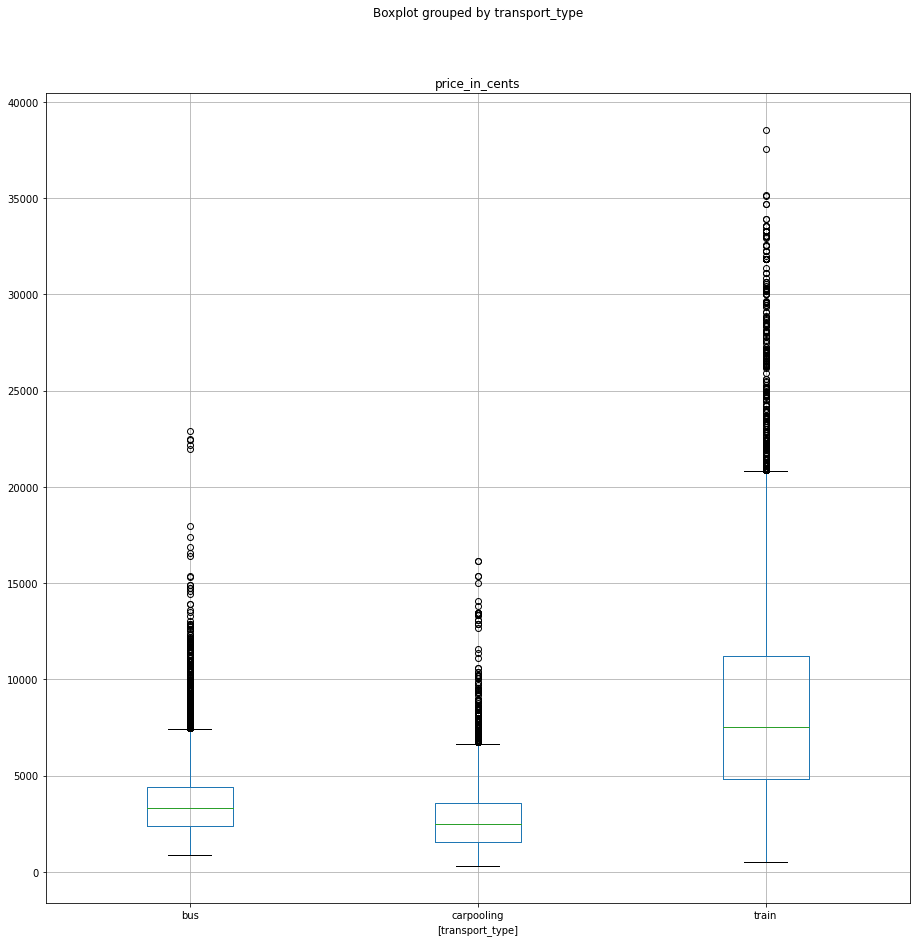

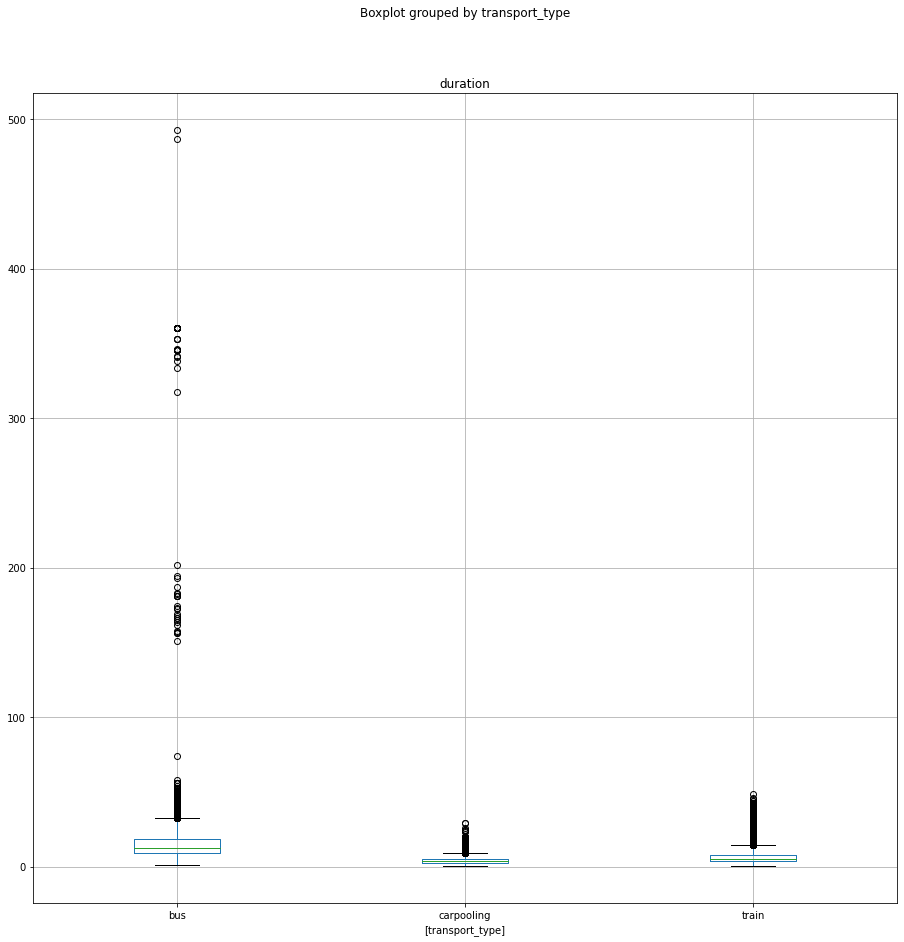

In [22]:
ax=All_data.boxplot(by=['transport_type'],column=['price_in_cents'],figsize =(15, 15))
ax=All_data.boxplot(by=['transport_type'],column=['duration'],figsize =(15, 15))


5.   Élimination des données inadéquates
 

In [23]:
All_data=removing_Outlier(All_data)
display(All_data)
# l'exportation de données qui seront utilisées ultérieurement dans le modèle de prédiction des prix
All_data[['company', 'price_in_cents','transport_type',
       'has_bicycle', 'has_adjustable_seats', 'has_plug', 'has_wifi', 'distance', 'duration','o_city','d_city']].to_csv('All_data.csv')

,id_x,o,d,company,price_in_cents,transport_type,has_bicycle,has_adjustable_seats,has_plug,has_wifi,fullname,traget,distance,duration,RangeDistance,o_city,d_city,keep
0,6795025,orleans,montpellier,8385,4550,carpooling,False,False,False,False,Blablacar,orleans to montpellier,503.136831,6.166667,481+km,611,542,True
5,6795030,paris,lille,8385,1800,carpooling,False,False,False,False,Blablacar,paris to lille,205.933671,3.000000,0-206km,628,453,True
6,6795031,paris,lille,8385,2150,carpooling,False,False,False,False,Blablacar,paris to lille,205.933671,2.500000,0-206km,628,453,True
7,6795032,paris,lille,8385,1700,carpooling,False,False,False,False,Blablacar,paris to lille,205.933671,2.500000,0-206km,628,453,True
8,6795033,paris,lille,8385,1700,carpooling,False,False,False,False,Blablacar,paris to lille,205.933671,2.833333,0-206km,628,453,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,paris,nantes,13,2590,bus,False,False,False,True,Flixbus,paris to nantes,339.046766,13.500000,207-339km,628,562,True
74164,6869185,paris,nantes,9,2700,bus,False,True,True,True,Ouibus,paris to nantes,339.046766,6.500000,207-339km,628,562,True
74165,6869187,paris,nantes,8371,3000,bus,False,True,True,True,Isilines,paris to nantes,339.046766,6.750000,207-339km,628,562,True
74166,6869189,paris,nantes,13,2880,bus,False,False,False,True,Flixbus,paris to nantes,339.046766,7.750000,207-339km,628,562,True


6.   Visualisation des prix et des durées selon les différents types de transport après élimination des données inadéquates


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


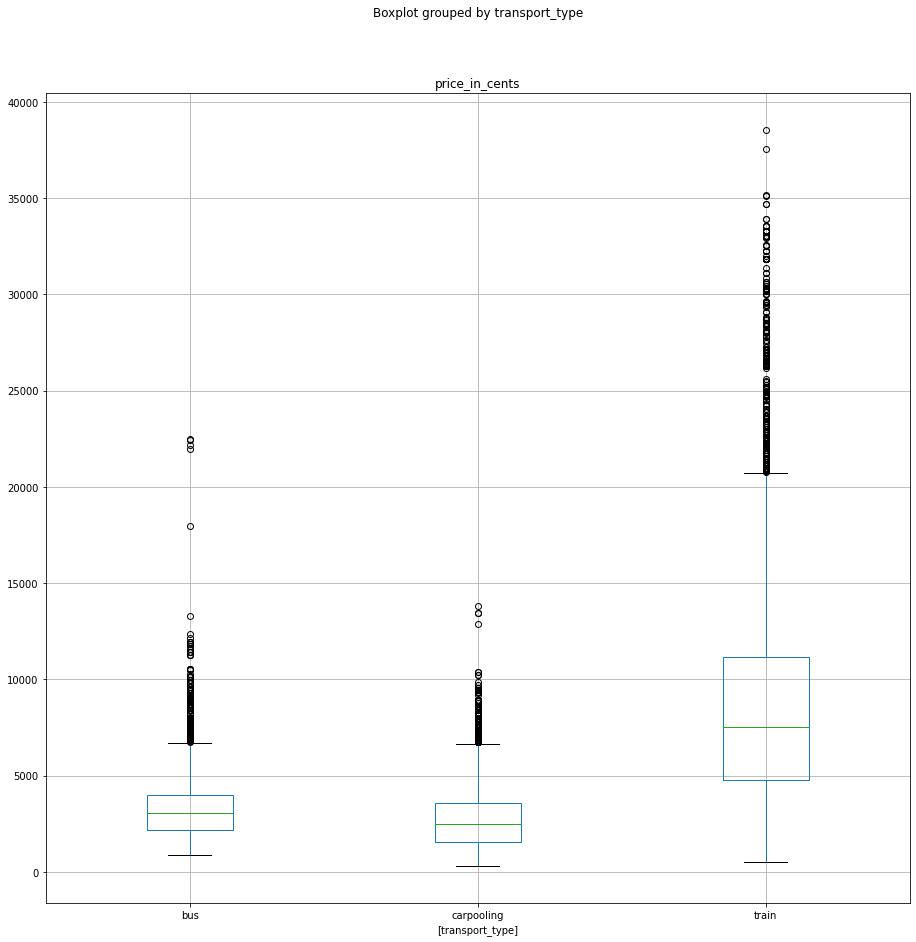

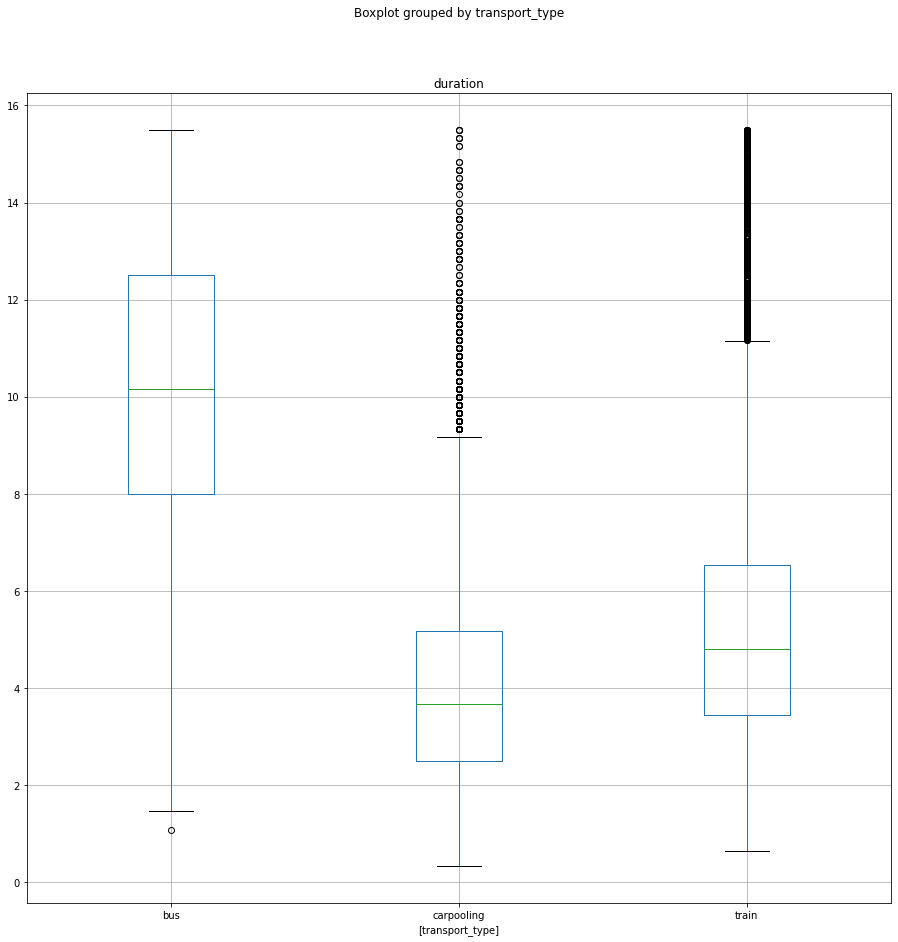

In [24]:
ax=All_data.boxplot(by=['transport_type'],column=['price_in_cents'],figsize =(15, 15))
ax=All_data.boxplot(by=['transport_type'],column=['duration'],figsize =(15, 15))


7.   Visualisation des prix et des durées en fonction des différents types de transport et des différentes sociétés de transport.


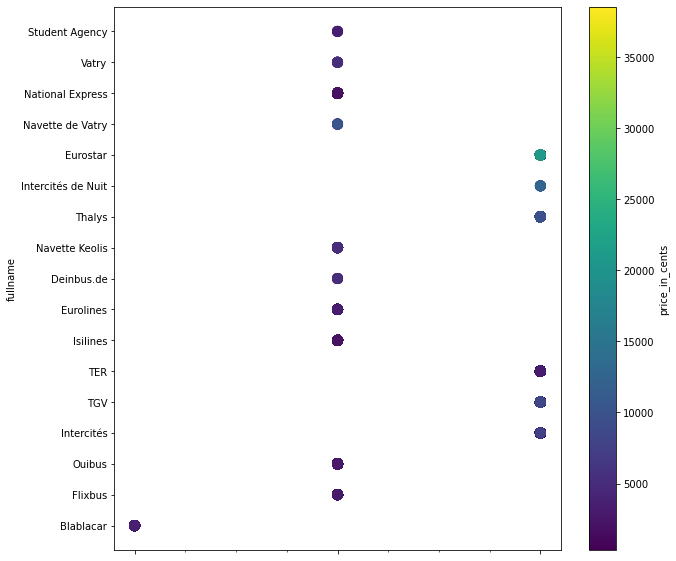

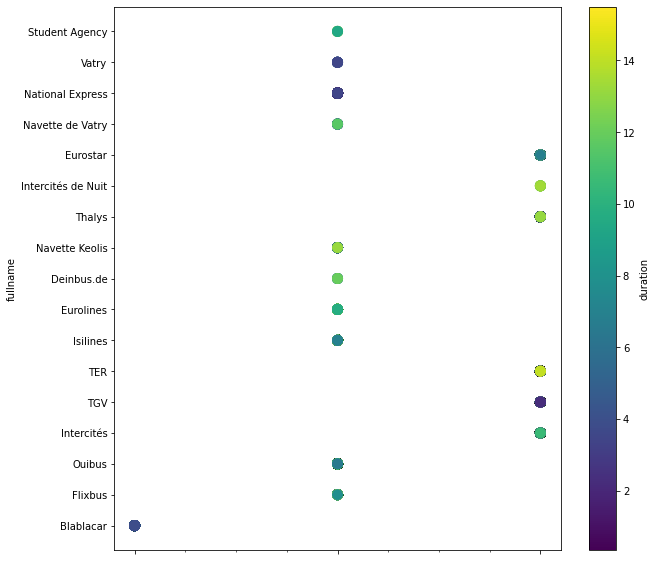

In [25]:
All_data.plot.scatter(x='transport_type', y='fullname', c='price_in_cents',cmap='viridis', s=100,figsize =(10, 10)) 
All_data.plot.scatter(x='transport_type', y='fullname', c='duration',cmap='viridis', s=100,figsize =(10, 10)) 


### Présentation des résultats



1. Presentation des prix min, moyen ,max et median par trajet et durée min, moyenne ,max et mediane par trajet



In [26]:
results1=All_data.groupby('traget').aggregate({'duration':['min','max','mean','median'],'price_in_cents':['min','max','mean','median']})
display(results1)

duration                                   \
                                         min        max       mean     median   
traget                                                                          
agde to amsterdam                   8.883333   8.950000   8.916667   8.916667   
agen to dijon                      12.400000  15.016667  13.708333  13.708333   
agen to marseille                   5.600000  12.333333   8.290000   7.958333   
agen to marseille-aeroport          5.000000   8.000000   5.833333   5.333333   
agen to paris                       9.666667  14.500000  12.166667  12.250000   
...                                      ...        ...        ...        ...   
villefranche-sur-cher to bordeaux   3.166667  14.750000   7.458333   5.841667   
vitre to nice                       9.883333  11.083333  10.483333  10.483333   
zurich to dijon                     8.166667   8.250000   8.208333   8.208333   
zurich to liege                     5.833333  11.500000   7.722222   5.833333   
zurich to strasbourg                4.916667  10.583333   7.000000   6.583333   

                                  price_in_cents                                
                                             min    max          mean   median  
traget                                                                          
agde to amsterdam                          19300  22000  20750.000000  20850.0  
agen to dijon                               9860  13650  11755.000000  11755.0  
agen to marseille                           2000   8920   4042.666667   3400.0  
agen to marseille-aeroport                  3700   4050   3833.333333   3800.0  
agen to paris                               2600   3190   2797.500000   2700.0  
...                                          ...    ...           ...      ...  
villefranche-sur-cher to bordeaux           3060   7670   5988.750000   6465.0  
vitre to nice                              15070  21920  18495.000000  18495.0  
zurich to dijon                             1400   2400   1900.000000   1900.0  
zurich to liege                             4050   4190   4096.666667   4050.0  
zurich to strasbourg                        1400   1780   1590.000000   1590.0  

[1294 rows x 8 columns]

2.   Présentation des différents prix moyens, min, max et médians et des temps moyens, min, max et médians selon les différents types de transport : train, bus et covoiturage et selon la distance du trajet : (0-206km),(207-339km),(340-481km) et (481+km) .

In [27]:
results2=All_data.groupby(['RangeDistance','transport_type']).aggregate({'duration':['min','max','mean','median'],'price_in_cents':['min','max','mean','median']})
display(results2)

duration                                   \
                                   min        max       mean     median   
RangeDistance transport_type                                              
0-206km       bus             1.083333  15.500000   7.093757   6.750000   
              carpooling      0.333333  14.333333   2.242571   2.333333   
              train           0.650000  15.500000   3.532682   2.900000   
207-339km     bus             2.483333  15.500000   9.081734   8.500000   
              carpooling      1.333333  14.333333   3.818259   3.666667   
              train           1.483333  15.433333   4.876881   4.083333   
340-481km     bus             4.483333  15.500000   9.886426   9.666667   
              carpooling      2.666667  13.500000   5.308721   5.166667   
              train           2.150000  15.500000   5.956007   5.466667   
481+km        bus             3.416667  15.500000  12.346061  12.500000   
              carpooling      3.833333  15.500000   7.797021   7.666667   
              train           2.516667  15.483333   6.690941   5.933333   

                             price_in_cents                                
                                        min    max          mean   median  
RangeDistance transport_type                                               
0-206km       bus                       850   9800   2088.541373   1984.0  
              carpooling                300  13450   1377.688039   1450.0  
              train                     490  25100   3712.950000   3350.0  
207-339km     bus                      1000  11810   2807.467053   2400.0  
              carpooling                950  13800   2587.597020   2650.0  
              train                    1400  31850   7359.501493   6295.0  
340-481km     bus                      1180  22480   3490.065702   3200.0  
              carpooling               1550   9200   3640.212252   3600.0  
              train                    2400  33900   9339.042849   8380.0  
481+km        bus                      1400  17980   3975.000000   3780.0  
              carpooling               2300  10400   5318.825556   5250.0  
              train                    1400  38550  11305.764356  11000.0